# Filtered Back Projection

In [ ]:
import torch
import pyronn
import numpy as np

## Working with Projection Data

We will demonstrate an example of reconstructing. To begin, we load the projections with Pytorch.

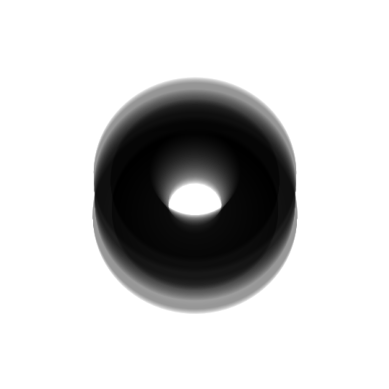

<Figure size 640x480 with 0 Axes>

In [3]:
from PythonTools import raw2py
import matplotlib.pyplot as plt
from get_natsorted_images import get_images_sorted
from PIL import Image
import torchvision.transforms as transforms

# Define folder and load image natually sorted. 
projection_folder = r"D:\simulated_data\circ_diff_reco_test\0001581_partstudio_00_model_ste_00_2048"
projection_paths = get_images_sorted(projection_folder)
images = list()
headers = list()
# Define basic transformation to get projections as tensors and with data range (0,1)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 65535,inplace = True)]) #For Range -1,1 : (32767.5, 32767.5)
for i,proj in enumerate(projection_paths):
    header, img = raw2py.raw2py(proj,switch_order=True)
    img = Image.fromarray(img)
    # Convert image to float before normalization
    img = img.convert('F')       
    images.append(transform(img).float())
    headers.append(header)

# Visualization of the images
# Create the figure and axis object
fig, ax = plt.subplots()

# Load a single image, transform to numpy array for plotting
image = images[5].cpu().squeeze().detach().numpy()

# Display the image
plt.figure()
ax.imshow(image, cmap="gray")
ax.axis('off')

# Show the figure
plt.show()


In [ ]:
from pyronn.ct_reconstruction.geometry.geometry import Geometry
geom = Geometry()
# Volume shape in Voxel, Volume spacing in mm
geom.init_from_EZRT_header(projection_headers =headers,volume_shape=[300,300,300],volume_spacing=0.5)

circ
circ


Since we already have some projections available, let's build a sinogram. In future, the following method should be included in the Pyro-NN Package:

In [5]:
def build_sinogram(images):
    n = len(images)
    nc = 1
    _, width, height = images[0].size()
    transformed_images = torch.zeros((nc, n, height, width), dtype=torch.float32)
    # 0 you get when you input 1. in a log function. The maximum value not being infinity is torch.finfo(torch.float32).eps
    transform = transforms.Compose([ transforms.Normalize(0,5)]) #-torch.log(torch.tensor(torch.finfo(torch.float32).eps))
    for i in range(0, n):
        transformed_images[:, i, :, :] = transform(-torch.log(images[i].float()))
    return transformed_images

sinogram = build_sinogram(images=images).cuda()

print("Shape of Sinogram: ",sinogram.shape)
print("Minimum Value in Sinogram: ",sinogram.flatten().min())
print("Maximum Value in Sinogram: ",sinogram.flatten().max())

Shape of Sinogram:  torch.Size([1, 90, 512, 512])
Minimum Value in Sinogram:  tensor(0.0055, device='cuda:0')
Maximum Value in Sinogram:  tensor(0.7568, device='cuda:0')


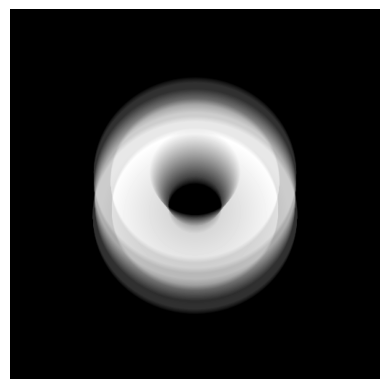

<Figure size 640x480 with 0 Axes>

In [6]:
# Visualization of the log transformed sinogram
# Create the figure and axis object
fig, ax = plt.subplots()

# Load a single image, transform to numpy array for plotting
image = sinogram[0][5].cpu().squeeze().detach().numpy()

# Display the image
plt.figure()
ax.imshow(image, cmap="gray")
ax.axis('off')

# Show the figure
plt.show()

Next, we need to initialize the reconstruction layer. For presentation purpose, we initialize all implemented layers.

In [7]:
from pyronn.ct_reconstruction.layers.backprojection_3d import ConeBackProjection3D
from pyronn.ct_reconstruction.layers.projection_3d import ConeProjection3D
from pyronn.ct_reconstruction.layers.projection_2d import FanProjection2D,ParallelProjection2D
from pyronn.ct_reconstruction.layers.backprojection_2d import FanBackProjection2D,ParallelBackProjection2D

# Cone Beam 3D Forward and Backward Projector
coneForwardProjection3D = ConeProjection3D(hardware_interp=True) # Reconstruction -> Sinogram
coneBackwardProjection3D = ConeBackProjection3D(hardware_interp=True) # Sinogram -> Reconstruction

# Fan Beam 2D Forward and Backward Projector
fanForwardProjection2D = FanProjection2D() # Reconstruction -> Sinogram
fanBackwardProjection2D = FanBackProjection2D() # Sinogram -> Reconstruction

# Parallel Beam 2D Forward and Backward Projector
parallelForwardProjection2D = ParallelProjection2D() # Reconstruction -> Sinogram
parallelBackwardProjection2D = ParallelBackProjection2D() # Sinogram -> Reconstruction

With all of those initialized, we can start reconstructing our projections. Hence, we will perform a basic filtered backprojection for a circular scan.

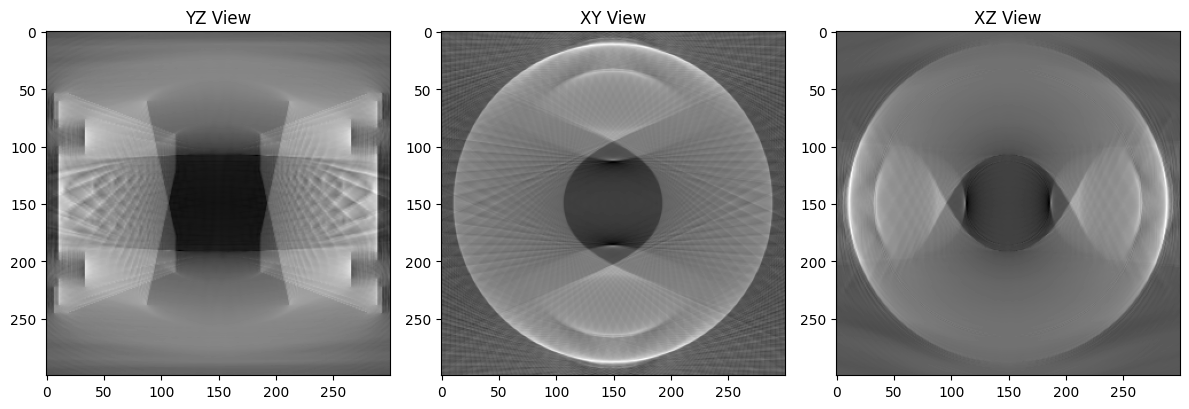

In [8]:
from pyronn.ct_reconstruction.helpers.filters.filters import ramp, ramp_3D, ram_lak_3D, shepp_logan_3D
from visualize_reconstruction import show_reco_views
from pyronn.ct_reconstruction.helpers.phantoms import shepp_logan

def FBP_ConeBeam(sinogram,geometry):
    reco_filter = torch.tensor(shepp_logan_3D(geometry.detector_shape,geometry.detector_spacing,geometry.number_of_projections),dtype=torch.float32).cuda()
    # Filter Sinogram in Fourier Domain
    x = torch.fft.fft(sinogram.cuda(),dim=-1,norm="ortho")
    x = torch.multiply(x,reco_filter)
    x = torch.fft.ifft(x,dim=-1,norm="ortho").real

    # Reconstruction
    reconstruction = coneBackwardProjection3D.forward(x.contiguous(), **geometry)

    return reconstruction

reconstruction = FBP_ConeBeam(sinogram,geom)
show_reco_views(reconstruction,geom)


## Advanced Examples

**Iterative Reconstruction**

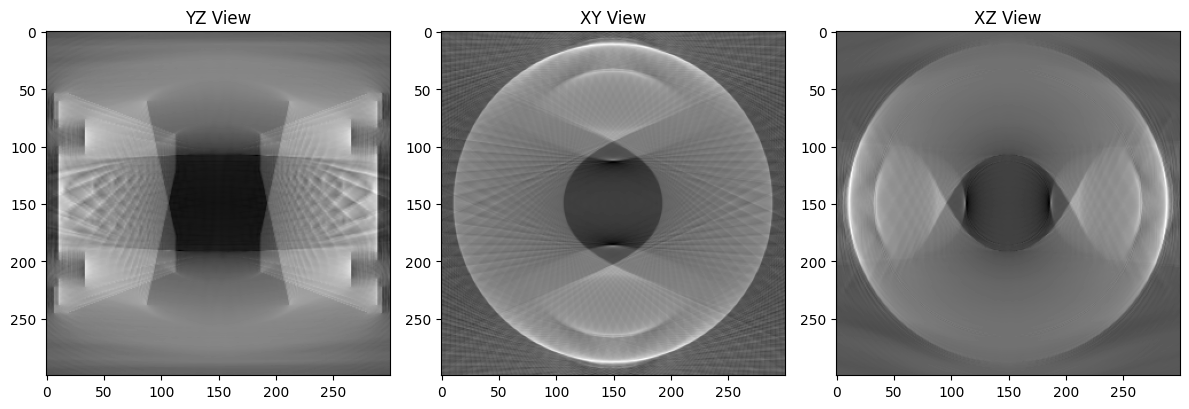

In [ ]:
def Iterative_reconstruction(sinogram, geometry, num_iterations):
    current_sino = None
    reco = torch.nn.Parameter(torch.unsqueeze(torch.full(size = geometry.volume_shape,fill_value=0.0, dtype=torch.float32), dim=0).float(),requires_grad=False).cuda()
    for i in range(num_iterations):
        current_sino = coneForwardProjection3D(reco,**geometry)

        #normalize current sinogram
        min_cs, max_cs = torch.min(current_sino.flatten()), torch.max(current_sino.flatten())
        if (max_cs - min_cs) != 0:
            current_sino=current_sino + min_cs
            current_sino = current_sino /(max_cs-min_cs)

        # calculate difference
        current_sino= current_sino - sinogram
        update = torch.multiply(2/(i+1),coneBackwardProjection3D(current_sino,**geometry))
        reco = reco -update

    return reconstruction

reconstruction = Iterative_reconstruction(sinogram,geom,18)
show_reco_views(reconstruction,geom)